In [1]:
pip install jsmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install h5netcdf 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install netcdf4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [9]:
import xarray as xr
import numpy as np
import cftime
import jsmetrics
import jsmetrics.metrics.jet_statistics as jet_statistics
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import math


In [10]:
# Función para mapear contourf con contour
def contour(data,contourdata,levels=np.arange(0,11),ccmap='PuBu',extend='max',limite_NS=42,clevels=np.arange(230,300,15),titulo='OLR y pr',cbarlabel='pr  [mm day$^{-1}$]'):
    lons,lats=data.lon,data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    contourdata, lon = add_cyclic_point(contourdata, coord=lons)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    cs=ax.contourf(lon,lats,data,levels=levels,cmap=ccmap,extend=extend,transform=ccrs.PlateCarree(),alpha=0.9)
    cc=ax.contour(lon,lats,contourdata,levels=clevels,colors='k',transform=ccrs.PlateCarree())
    ax.clabel(cc, cc.levels, inline=True, fontsize=10)
    ax.set_extent([-180,180, -limite_NS, limite_NS], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    plt.title(titulo,fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.046, pad=0.06)
    cbar.ax.set_xlabel(cbarlabel)

In [11]:
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(xlab,fontsize=10)
    plt.ylabel(ylab,fontsize=10)
    plt.title(title,fontsize=11)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=8)


<a name='title'></a>
 **<font color="Purple"> Funciones </font>**
---

###### 1. Primer paso es subir los archivos 
###### 2. Abrir archivos y seleccionar variables a usar


In [12]:
#Seleccionar archivos del historical
u_filename='ua_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'
v_filename='va_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'

In [13]:
# Seleccionar variables del archivo historical
u_ds=xr.open_dataset(u_filename)
ua=u_ds['ua']  #viento zonal
v_ds=xr.open_dataset(v_filename)
va=v_ds['va']  #viento meridional

In [14]:
# Seleccionar archivos del ssp585
u_filename585 = 'ua_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'
v_filename585='va_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'

In [15]:
# Seleccionar variables del archivo ssp585
u_ds585=xr.open_dataset(u_filename585)
ua585=u_ds585['ua']
v_ds585=xr.open_dataset(v_filename585)
va585=v_ds585['va']

###### <h1  style="color:rebeccapurple; font-size:17px;"><i>Climatología de viento zonal en <b> un nivel de presión</b> </i> </h1>
#####   - `Anual`
#####   - `Estacional`





In [16]:
def zonal_mean_anual (ua,va,nivel,año):
    """ 
    Esta función va a promediar en tiempo (anual) el viento zonal sobre un nivel de presión 
    
    ua: viento zonal
    va: viento meridional
    nivel: nivel de presión sobre el que se hará el proceso (verificar unidades)
    año: a partir de qué año 
    
    """
    anualu = None
    anualv = None
    
    for i, componente in enumerate([ua, va]):
        #Seleccionar el nivel de presión (está en Pa) y los años (según la simulación)
        level = componente.sel(plev=nivel).where(componente.time.dt.year >= año, drop=True) #tal vez año podría estar fuera de la función
        anual = level.groupby(level.time.dt.year).mean(dim='time')     #???
               
        if i == 0:
            anualu = anual
        elif i == 1:
            anualv = anual
    
    #magnitud de vector con componentes u,v     
    magnitud = np.sqrt(anualu**2 + anualv**2) 
    
    return magnitud

In [17]:
#zonal_mean_anual(ua,va,20000,1979)

In [18]:
def zonal_mean_seasons (ua,va,nivel,año):
    """ 
    Esta función va a promediar en tiempo el viento zonal  sobre un nivel de presión y 
    agruparlo por estaciones
    
    ua: viento zonal
    va: viento meridional
    nivel: nivel de presión sobre el que se hará el proceso
    año: a partir de qué año 
    
    Return:
    magnitud: un diccionario con la magnitud del viento para cada estación.
    """
   
    estaciones_u = {}
    estaciones_v = {}

    for i, componente in enumerate([ua, va]):
        level = componente.sel(plev=nivel).where(componente.time.dt.year >= año, drop=True)
        season = level.groupby(level.time.dt.season).mean(dim='time')

    # Asigna los resultados a diccionarios según la iteración
        if i == 0:
            for estacion in season.season.values:
                estaciones_u[estacion] = season.sel(season=estacion)
        elif i == 1:
            for estacion in season.season.values:
                estaciones_v[estacion] = season.sel(season=estacion)
    
    # Calcula la magnitud del vector para cada estación
    magnitud = {}
    # select = season[]
    
    for estacion in estaciones_u.keys():
        magnitud[estacion] = np.sqrt(estaciones_u[estacion]**2 + estaciones_v[estacion]**2)
        
    estaciones = list(estaciones_u.keys())
    estacion_idx = int(input("Elige una estación (0: DJF, 1: MAM, 2: JJA, 3: SON): "))
    select = estaciones[estacion_idx]
    
    # Magnitud del viento para la estación seleccionada
    select_uv = magnitud[select]
    
    return magnitud, select_uv

In [19]:
#zonal_mean_seasons(ua,va,20000,1979)

In [20]:
#esta solo para comprobar 
def zonal_mean_winter (ua,va,nivel,año):
    """ 
    Esta función va a promediar en tiempo el viento zonal  sobre un nivel de presión y 
    agruparlo por estaciones
    
    ua: viento zonal
    va: viento meridional
    nivel: nivel de presión sobre el que se hará el proceso
    año: a partir de qué año 
    
    """
    # Inicializa las variables para almacenar los resultados de u y v
    inviernou = None
    inviernov = None

    # Itera sobre las componentes ua y va
    for i, componente in enumerate([ua, va]):
        #Seleccionar el nivel de presión (está en Pa) y los años (según la simulación)
        level = componente.sel(plev=nivel).where(componente.time.dt.year >= año, drop=True) #tal vez año podría estar fuera de la función
        season = level.groupby(level.time.dt.season).mean(dim='time')
        invierno = season[0] #todas las estaciones?

        #Asigna los resultados a u (inviernou) e inviernov (v) según la iteración
        if i == 0:
            inviernou = invierno
        elif i == 1:
            inviernov = invierno
    
    #magnitud de vector con componentes u,v
    magnitud = np.sqrt(inviernou**2 + inviernov**2) 
    
    return magnitud

In [21]:
#zonal_mean_winter (ua,va,20000,1979)

###### <h1  style="color:rebeccapurple; font-size:17px;"><i>Diferencia entre viento zonal, usando dos sets de datos (Simulación 1 vs Simulación 2) <b> un nivel de presión</b> </i> </h1>
#####   - `Anual`
#####   - `Estacional`


In [22]:
def groupby_seasons(componente, nivel, año):
    """
    Función auxiliar para seleccionar el nivel de presión y agrupar por estación,
    componente: va a ser u, v, o los años (enla otra función) 
    nivel: nivel de presión sobre el que se hará el proceso
    año: a partir de qué año 
    """
    level = componente.sel(plev=nivel).where(componente.time.dt.year >= año, drop=True)
    seasons = level.groupby(level.time.dt.season).mean(dim='time')
    return seasons

def zonal_mean_diff_seasons(ua1, va1, ua2, va2, nivel, año1, año2):
    """ 
    Esta función promedia en tiempo el viento zonal y meridional para dos simulaciones y obtiene la 
    diferencia entre ambas en el mismo nivel de presión.

    Parámetros:
    nivel: Nivel de presión sobre el que se hará el proceso para ambas simulaciones.
    
    ua1, va1: Componentes del viento (zonal y meridional) de la simulación 1.
    ua2, va2: Componentes del viento (zonal y meridional) de la simulación 2.
    
    año1: Año a partir del cual se procesará la simulación 1.
    año2: Año a partir del cual se procesará la simulación 2.

    Return:
    Un diccionario con los resultados de ambas simulaciones y sus diferencias.
 
    """
    # Inicializa diccionarios para almacenar los resultados por estación
    resultados1 = {}
    resultados2 = {}
    diferencias ={}

    # Itera sobre los componentes (ua1, va1, ua2, va2)
    for i, (componente, año) in enumerate(zip([ua1, va1, ua2, va2], [año1, año1, año2, año2])):
        estacional = groupby_seasons(componente, nivel, año)
        if i < 2:  # Para la simulación 1
            for estacion in estacional.season.values: #devuelve una lista de las estaciones presentes en los dato
                if estacion not in resultados1:
                    resultados1[estacion] = {} #diccionario que almacena los resultados de la primera simulación
                resultados1[estacion][f"componente_{i+1}"] = estacional.sel(season=estacion)
        else:  # Para la simulación 2
            for estacion in estacional.season.values:
                if estacion not in resultados2:
                    resultados2[estacion] = {}
                resultados2[estacion][f"componente_{i-1}"] = estacional.sel(season=estacion)
        
      
    for estacion in resultados1.keys():
        diferencias[estacion] = {
            componente: resultados2[estacion][componente] - resultados1[estacion][componente]
            for componente in resultados1[estacion].keys()
        }
        
    return {
    'r1': resultados1,
    'r2': resultados2,
    'diff': diferencias
}


In [23]:
#zonal_mean_diff_seasons(ua, va, ua585, va585, 20000, 1979, 2070)

###### <h1  style="color:rebeccapurple; font-size:17px;"><i>Climatología del viento zonal y temperatura en <b> un nivel de presión</b> </i> </h1>
#####   - `Anual`
#####   - `Estacional`


In [24]:
def temp_nivel(tas, nivel, año):
    """
    Esta función calcula el promedio de temperatura en un nivel de presión elegido y devuelve:
    - El promedio anual
    - El promedio por estaciones
    - El promedio de la estación de invierno (DJF)
    
    Parámetros:
    tas: temperatura
    nivel: nivel de presión en el que se hará el proceso
    año: año a partir del cual se considerarán los datos
    """
    # Seleccionar el nivel de presión y filtrar por año
    level = tas.sel(plev=nivel).where(tas.time.dt.year >= año, drop=True)
    
    # Calcular el promedio anual
    anual = level.groupby(level.time.dt.year).mean(dim='time')
    
    # Calcular el promedio por estaciones
    season = level.groupby(level.time.dt.season).mean(dim='time')
    
    # Obtener el promedio para invierno (DJF)
    invierno = season.sel(season='DJF')
    
    # Retornar los tres resultados
    return anual, season, invierno


In [25]:
#temp_nivel(tas, nivel, año)

###### <h1  style="color:rebeccapurple; font-size:17px;"><i> Sección transversal del jet subtropical </i> </h1>
#####   - `Anual`
#####   - `Estacional`


In [26]:
def transversal_anual (ua,nivel_A,nivel_B):
    """
    Esta función genera la sección trasnversal del jet entre dos niveles de presión elegidos
    ua: set de datos
    nivel_A: mayor presión 
    nivel_B: menor presión
    """
    sección = ua.sel(plev=slice(nivel_A, nivel_B))
    ua_clima = sección.groupby('time.year').mean(dim=['time','lon']) #checar si no hay problema de hacer los mean al mismo tiempo
    año = ua_clima.mean(dim='year')
    season = sección.groupby('time.season').mean(dim=['time','lon'])
    mensual = sección.groupby('time.month').mean(dim=['time','lon'])
    
    #estos o por estacion
    OND = mensual.sel(month=[10, 11, 12]).mean(dim='month')
    NDJ = mensual.sel(month=[11, 12, 1]).mean(dim='month')
    DJF = mensual.sel(month=[12, 1, 2]).mean(dim='month')
    JFM = mensual.sel(month=[1, 2, 3]).mean(dim='month')

    return {'anual':año,'estación':season,'OND': OND, 'NDJ': NDJ, 'DJF': DJF, 'JFM': JFM} 

In [27]:
#transversal_anual (ua,100000,5000)

In [28]:
def transversal (ua,nivel_A,nivel_B):
    """
    Esta función genera la sección trasnversal del jet entre dos niveles de presión elegidos
    ua: set de datos
    nivel_A: mayor presión 
    nivel_B: menor presión
    """
    sección = ua.sel(plev=slice(nivel_A, nivel_B))
    ua_clima = sección.groupby('time.year').mean(dim=['time','lon']) #checar si no hay problema de hacer los mean al mismo tiempo
    anual = ua_clima.mean(dim='year')
    mensual = sección.groupby('time.month').mean(dim=['time','lon']) 

    #estos o por estacion
    OND = mensual.sel(month=[10, 11, 12]).mean(dim='month')
    NDJ = mensual.sel(month=[11, 12, 1]).mean(dim='month')
    DJF = mensual.sel(month=[12, 1, 2]).mean(dim='month')
    JFM = mensual.sel(month=[1, 2, 3]).mean(dim='month')

    return {'OND': OND, 'NDJ': NDJ, 'DJF': DJF, 'JFM': JFM} 
#LUEGO TENGO QUE LLAMAR LA FUNCIÓN DE CONTROURF PARA CADA UNO 

In [29]:
#transversal (ua,100000,5000)

###### <h1  style="color:rebeccapurple; font-size:17px;"><i> Estadística </i> </h1>
#####   - `Anual` y `en una región`



In [30]:
def recortes (ua1,va1,ua2,va2,latA,latB,lonA,lonB,año1,año2):
    """
    Esta función nos recortará los datos (años,latitudes, longitudes) para usarlos en otras funciones 
    ua1,va1: viento (zonal,meridional) de la simulación 1 
    ua2,va2:  viento (zonal,meridional) de la simulación 2
    latA,latB: recorte de latitudes de menor (A) a mayor (B)
    lonA,lonB: recorte de longitudes de menor (A) a mayor (B)
    """
    ua1["plev"]=ua1["plev"]/100
    ua2["plev"]=ua2["plev"]/100

    ua1['units']='hPa'
    ua2['units']='hPa'

    ua1 = ua1.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(ua1.time.dt.year > año1, drop=True)
    va1 = va1.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(va1.time.dt.year > año1, drop=True)
    
    ua2 = ua2.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(ua2.time.dt.year > año2, drop=True)
    va2 = va2.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(va2.time.dt.year > año2, drop=True)
    
    #Recorte para la temporada invernal en el HN
    
    ua1=ua1.where((ua1.time.dt.month==12)| (ua1.time.dt.month==1)| (ua1.time.dt.month==2),drop=True)
    va1=va1.where((va.time.dt.month==12)| (va1.time.dt.month==1)| (va1.time.dt.month==2),drop=True)

    ua2=ua2.where((ua2.time.dt.month==12)| (ua2.time.dt.month==1)| (ua2.time.dt.month==2),drop=True)
    va2=va2.where((va2.time.dt.month==12)| (va2.time.dt.month==1)| (va2.time.dt.month==2),drop=True)
    
    return {'ua1': ua1, 'va1': va1, 'ua2': ua2, 'va2': va2}

In [31]:
def js_pos_intens (ua1,ua2,nivel):
    """
    Esta función encuentra la posición promedio y la intensidad, usando el método de Woollings et al. 2010
    ua1: Viento zonal de la simulación 1 (ua1)
    ua2: Viento zonal de la simulación 2 (ua2)
    nivel: a qué nivel de presión se hará el cálculo, en Pa
    
    """
    
    #Convertir el tiempo a gregoriano 
    ua1 = ua1.convert_calendar(calendar='gregorian', align_on='year')
    ua2 = ua2.convert_calendar(calendar='gregorian', align_on='year')
    
    #Usamos jsmetrics statistics
    sim1 = jsmetrics.jet_statistics.woollings_et_al_2010(ua1.sel(plev=nivel),filter_freq=4,window_size=20)

    sim2 = jsmetrics.jet_statistics.woollings_et_al_2010(ua2.sel(plev=nivel),filter_freq=4,window_size=20)
    
    #POSICIÓN
    sim1_p=sim1["jet_lat"].groupby(sim1["jet_lat"].time.dt.year).mean() 
    sim2_p=sim2["jet_lat"].groupby(sim2["jet_lat"].time.dt.year).mean()  
    
    #VELOCIDAD
    sim1_v=sim1["jet_speed"].groupby(sim1["jet_speed"].time.dt.year).mean()  
    sim2_v=sim2["jet_speed"].groupby(sim2["jet_speed"].time.dt.year).mean() 
    
    return {'Posición del jet en simulación 1':sim1_p,
            'Posición del jet en simulación 2':sim2_p,
            'Velocidad del jet en simulación 1':sim1_v,
            'Velocidad del jet en simulación 2':sim2_v,
            }

In [32]:
#recortes tiene argumentos(ua1,va1,ua2,va2,latA,latB,lonA,lonB,año1,año2)
recorteR = recortes(ua,va,ua585,va585,10,40,67,129,1978,2069)

In [33]:
recorteR #ya está en hPa

{'ua1': <xarray.DataArray 'ua' (time: 108, plev: 19, lat: 25, lon: 33)> Size: 7MB
 array([[[[-1.00373535e+01, -9.73950195e+00, -9.45703125e+00, ...,
                       nan,             nan,             nan],
          [-1.00344238e+01, -9.67944336e+00, -9.34082031e+00, ...,
                       nan, -6.15234375e+00, -6.62220001e+00],
          [-9.91845703e+00, -9.52490234e+00, -9.09814453e+00, ...,
           -1.27614746e+01, -1.15314941e+01, -1.08188477e+01],
          ...,
          [ 6.01928711e+00,  5.64526367e+00,  1.91546941e+00, ...,
            6.09346724e+00,  6.99245453e+00,  7.90395832e+00],
          [ 6.64721680e+00,  5.02099609e+00, -3.89826059e-01, ...,
            4.73524714e+00,  5.76099634e+00,  6.87148857e+00],
          [ 7.00073242e+00,  3.13875008e+00,             nan, ...,
            2.97003508e+00,  3.86788988e+00,  5.29230022e+00]],
 
         [[-1.13398438e+01, -1.10424805e+01, -1.06806641e+01, ...,
           -2.84545898e+00, -3.43579102e+00, -5.54199

In [34]:
#js_pos_intens tiene argumentos (ua1,ua2,nivel) NIVEL ESTÁ EN hPa o en Pa???
POS_VEL = js_pos_intens(recorteR['ua1'], recorteR['ua2'],200)

In [35]:
POS_VEL

{'Posición del jet en simulación 1': <xarray.DataArray 'jet_lat' (year: 36)> Size: 288B
 array([35.41666667, 30.41666667, 35.        , 32.08333333, 32.5       ,
        31.66666667, 30.41666667, 29.58333333, 32.91666667, 32.5       ,
        32.08333333, 32.5       , 30.83333333, 28.75      , 30.        ,
        33.33333333, 30.        , 30.        , 31.66666667, 32.08333333,
        31.25      , 32.91666667, 32.5       , 31.25      , 33.75      ,
        30.        , 35.41666667, 31.25      , 32.91666667, 36.25      ,
        31.66666667, 32.08333333, 28.33333333, 32.5       , 35.        ,
        31.25      ])
 Coordinates:
     plev     float64 8B 200.0
     units    <U3 12B 'hPa'
   * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014,
 'Posición del jet en simulación 2': <xarray.DataArray 'jet_lat' (year: 31)> Size: 248B
 array([30.        , 31.66666667, 33.75      , 30.        , 30.83333333,
        30.41666667, 28.75      , 35.        , 29.58333333, 27.

Nombre de la simulación 1:  d
Nombre de la simulación 2:  d
Nombre de la simulación 1:  odio
Nombre de la simulación 2:  esot


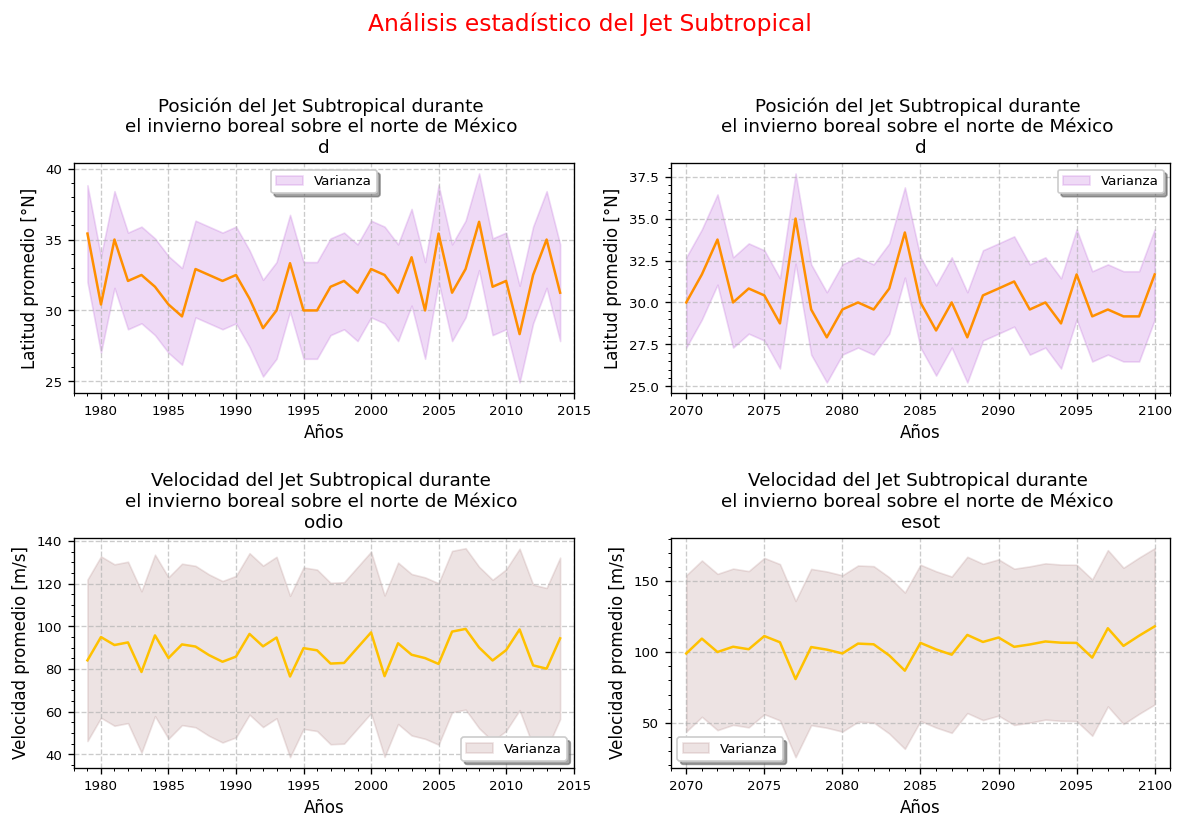

In [37]:
#varianza toma los argumentos (sim1_p,sim2_p,sim1_v,sim2_v)
VAR = varianza(POS_VEL['Posición del jet en simulación 1'],
               POS_VEL['Posición del jet en simulación 2'],
               POS_VEL['Velocidad del jet en simulación 1'],
               POS_VEL['Velocidad del jet en simulación 2'])

In [51]:
def varianza1a1(sim1_p, sim1_v):
    # Varianza de posición
    var_1p = sim1_p.var().round(2)
    mean_1p = sim1_p.round(2)
    
    # Varianza de velocidad
    var_1v = sim1_v.var().round(2)
    mean_1v = sim1_v.round(2)
    
    # Datos para graficar varianza y medias
    graf_mean = [mean_1p, mean_1v]
    graf_var = [var_1p, var_1v]
    colors = ["#FF8F00", "#FF8F00"]
    colorf = ["#AF47D2", "#AF47D2"]
    eje = ["Latitud promedio [°N]", "Velocidad promedio [m/s]"]
    titulo = [
        [input("Nombre de la simulación 1: "), "Posición"],
        [input("Nombre de la simulación 1: "), "Velocidad"]
    ]

    # Crear la figura y los subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 7), dpi=120)  # 2 filas, 1 columna

    # Iterar para cada gráfico (latitud y velocidad)
    for i, value in enumerate(graf_mean):
        ax = axs[i]
        ax.plot(value.year, value, color=colors[i])
        ax.fill_between(value.year, value + graf_var[i], value - graf_var[i], alpha=0.2, color=colorf[i], label="Varianza")
        ax.set_xlim([value.year.min() - 1, value.year.max() + 1])
        ax.set_xlabel("Años")
        ax.set_ylabel(eje[i])
        ax.set_title(f"{titulo[i][1]} del Jet Subtropical durante \nel invierno boreal sobre el norte de México \n{titulo[i][0]}")
        ax.legend()

    # Ajustar el layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle("Análisis estadístico del Jet Subtropical\n", fontsize=14, color="red")
    
    # Mostrar el gráfico
    plt.show()
    
    return fig


In [38]:
#varianza (sim1_p,sim2_p,sim1_v,sim2_v):

In [39]:
def prob_posicion(ua1, ua2, nivel):
    # Solicitar títulos para las simulaciones
    titulo_sim1 = input("Título simulación 1: ")
    titulo_sim2 = input("Título simulación 2: ")
    sim1 = jsmetrics.jet_statistics.woollings_et_al_2010(ua1.sel(plev=nivel), filter_freq=4, window_size=20)
    sim2 = jsmetrics.jet_statistics.woollings_et_al_2010(ua2.sel(plev=nivel), filter_freq=4, window_size=20)
   
    # Crear diccionario con resultados de las posiciones del Jet
    d_lat = {
        f'Posición del Jet Subtropical sobre el Norte de México durante el invierno boreal\n{titulo_sim1}': sim1['jet_lat'],
        f'Posición del Jet Subtropical sobre el Norte de México durante el invierno boreal\n{titulo_sim2}': sim2['jet_lat']
    }
    
    # Convertir calendario a gregoriano
    ua1 = ua1.convert_calendar(calendar='gregorian', align_on='year')
    ua2 = ua2.convert_calendar(calendar='gregorian', align_on='year')
    
    # Configuración de la gráfica
    plt.figure(figsize=(23, 5), dpi=130)
    for i, (k, v) in enumerate(d_lat.items(), start=1):
        plt.subplot(1, len(d_lat), i)

        # Aplanar los datos y crear histograma
        valores_M = v.data.flatten()
        plt.hist(valores_M, bins=7, density=True, histtype='stepfilled', facecolor='b', alpha=0.75)

        # Calcular y mostrar la media
        media = v.mean().values
        plt.axvline(media, color="red", linewidth=1, linestyle="dashed", label=f'Media={media:.2f}')

        # Configuración del plot
        lineplot_setup(None, None, '$Latitud$', 'Densidad de probabilidad', title=f'Distribución para {k}', legend=True)

    plt.tight_layout()
    plt.show()

    return plt.gcf()


Título simulación 1:  dxd
Título simulación 2:  dxd


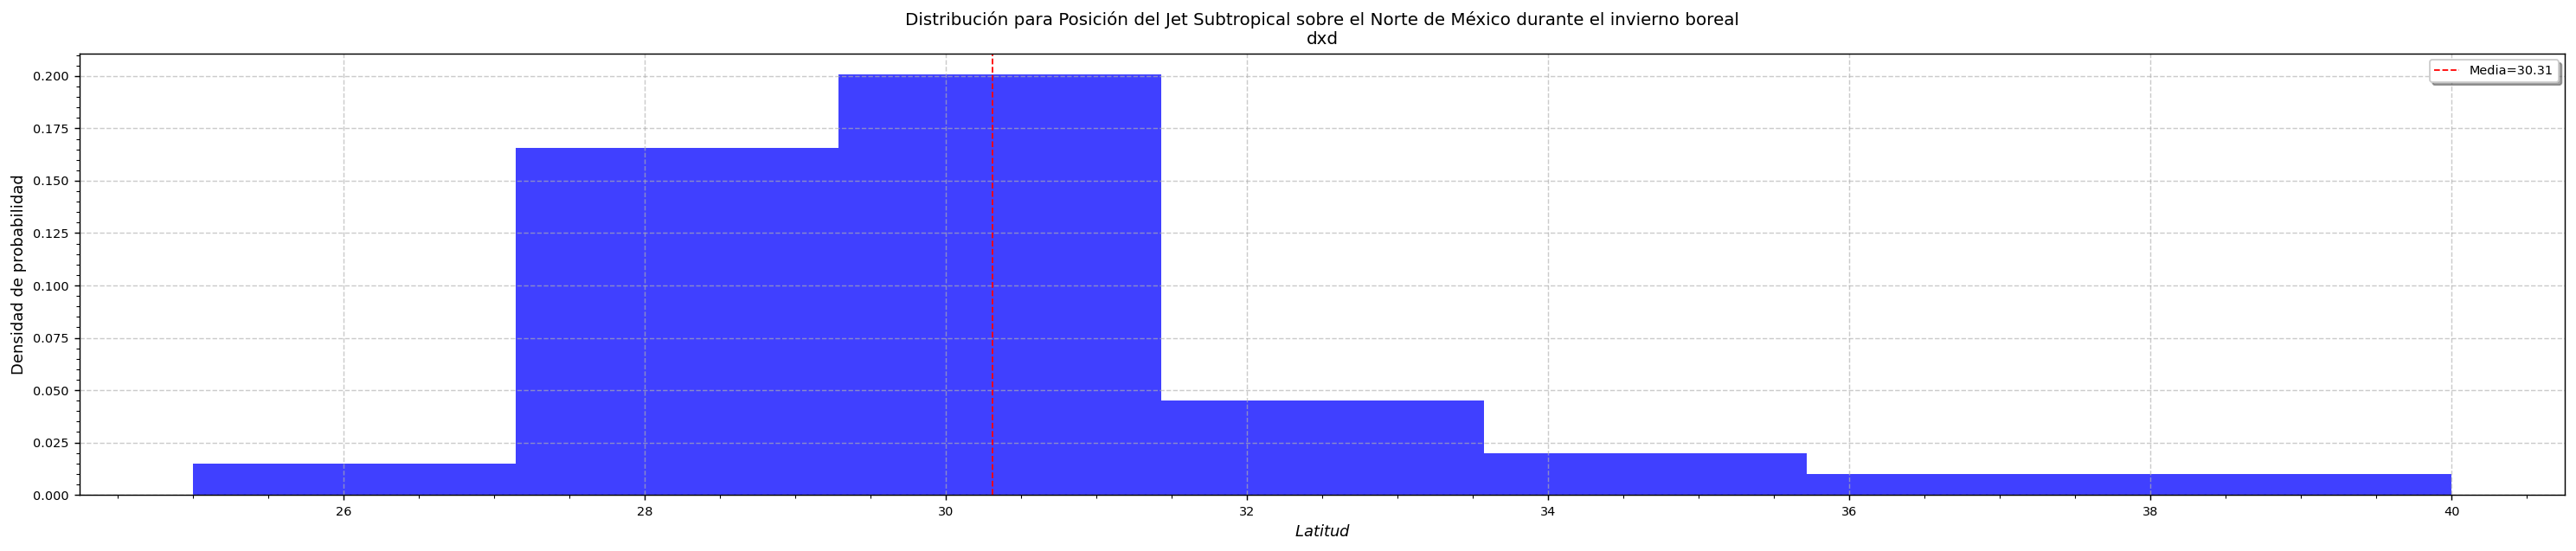

<Figure size 640x480 with 0 Axes>

In [40]:
PROB_POS = prob_posicion(recorteR['ua1'], recorteR['ua2'],200) #nivel en hPa?

In [41]:
def prob_vel (ua1,ua2, nivel):
    titulo_sim1 = input("Título simulación 1: ")
    titulo_sim2 = input("Título simulación 2: ")
    sim1 = jsmetrics.jet_statistics.woollings_et_al_2010(ua1.sel(plev=nivel), filter_freq=4, window_size=20)
    sim2 = jsmetrics.jet_statistics.woollings_et_al_2010(ua2.sel(plev=nivel), filter_freq=4, window_size=20)
    
    d_vel = {
        f'velocidad del Jet Subtropical sobre el Norte de México durante el invierno boreal\n{titulo_sim1}': sim1['jet_speed'],
        f'velocidad del Jet Subtropical sobre el Norte de México durante el invierno boreal\n{titulo_sim2}': sim2['jet_speed']
    }

    # Convertir calendario a gregoriano
    ua1 = ua1.convert_calendar(calendar='gregorian', align_on='year')
    ua2 = ua2.convert_calendar(calendar='gregorian', align_on='year')


    plt.figure(figsize=(23, 5), dpi=130)
    for i, (k, v) in enumerate(d_vel.items(), start=1):
        plt.subplot(1, len(d_vel), i)
        valores_M = v.data.flatten()
        plt.hist(valores_M, bins=20, density=True, histtype='stepfilled', facecolor='b', alpha=0.75)
        media = v.mean()
        plt.axvline(media, color="red", linewidth=1, linestyle="dashed", label=f'Media={media.values:.2f}')

        media=v.mean()
        lineplot_setup(None, None, '$Velocidad(m/s)$', 'Densidad de probabilidad', title=f'Distribución para {k}', legend=True)
    plt.tight_layout()
    plt.show()
    return plt.gcf

Título simulación 1:  dx
Título simulación 2:  d


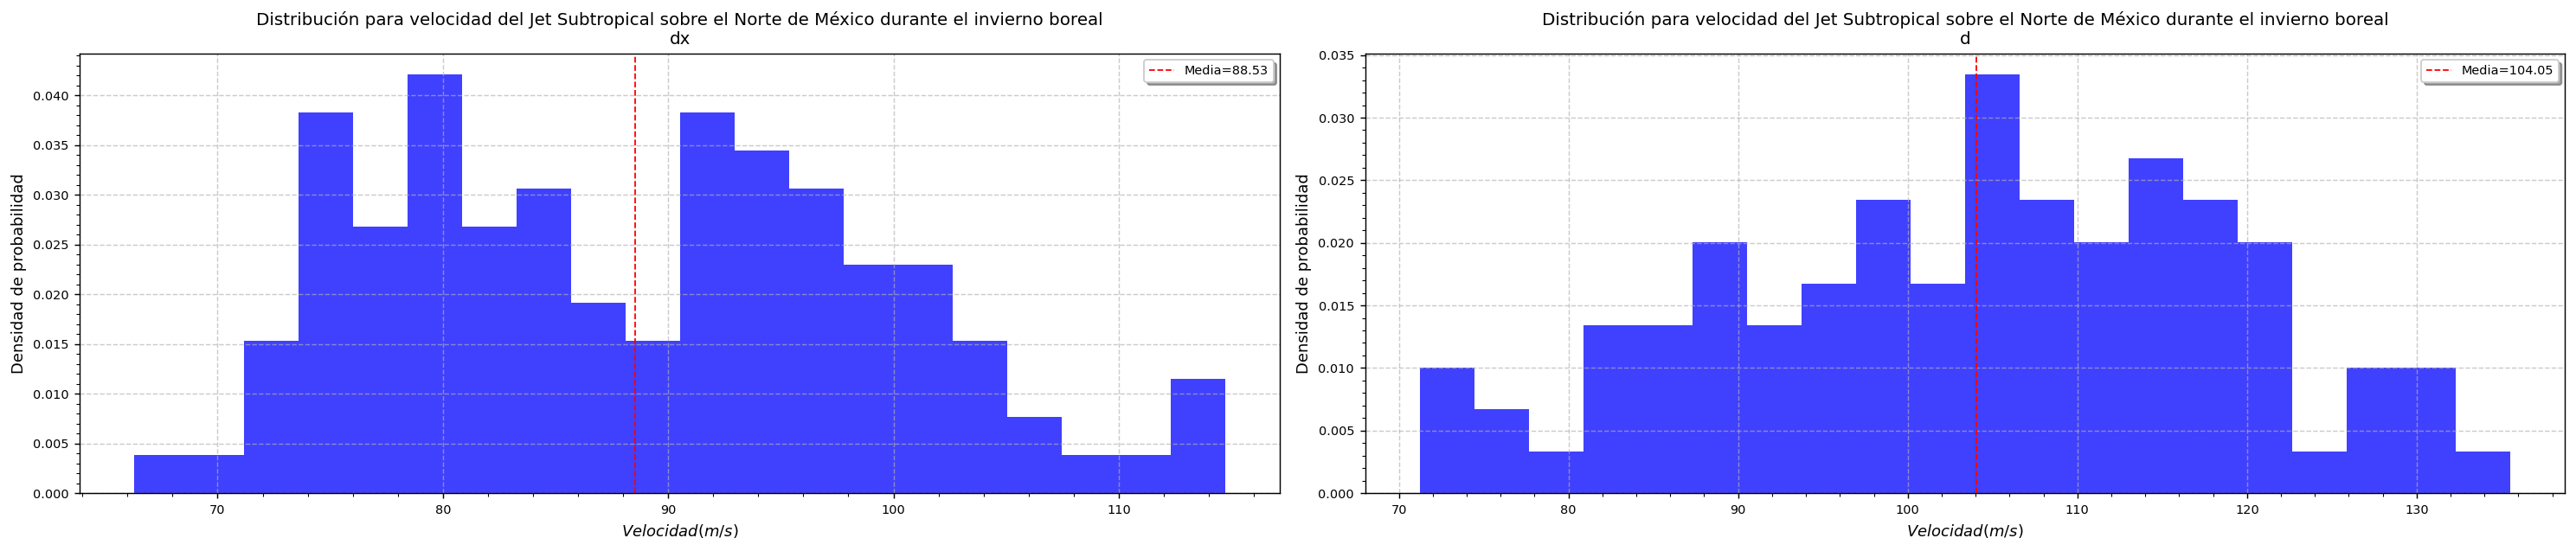

In [42]:
PROB_VEL = prob_vel(recorteR['ua1'], recorteR['ua2'],200) #nivel en hPa?

###### <h1  style="color:rebeccapurple; font-size:17px;"><i> Posición del STJ siguiendo metología de Liu et al (2021)</i> </h1>
#####   - `Anual` y `en una región ya elegida`



In [43]:
#Definimos la posición del STJ como la latitud del valor máximo encontrado en el campo de diferencia entre el viento zonalde la
#troposfera superior (250 hPa) y el viento zonal de la troposfera inferior (850 hPa)promediado en una banda de longitud dada entre 10° y 40°N.

def method_Liu(ua1,va1,ua2,va2,ts,ti):
    """
    ua1: viento zonal de simulación 1
    ua2: viento zonal de simulación 2
    ts: nivel de presión menor (trofosfera superior,unidades en Pa)
    ti: nivel de presión mayor (trofosfera inferior, unidades en Pa) 
    """
    
    sup1u = ua1.where(ua1["plev"]==ts,drop=True).mean("time")
    sup1v = va1.where(va1["plev"]==ts,drop=True).mean("time")
    
    sup2u = ua2.where(ua2["plev"]==ts,drop=True).mean("time")
    sup2v = va2.where(va2["plev"]==ts,drop=True).mean("time")
    
    inf1u = ua1.where(ua1["plev"]==ti,drop=True).mean("time")
    inf1v = va1.where(va1["plev"]==ti,drop=True).mean("time")
    
    inf2u = ua2.where(ua2["plev"]==ti,drop=True).mean("time")
    inf2v = va2.where(va2["plev"]==ti,drop=True).mean("time")

  
    zonalts1= np.sqrt(sup1u**2 + sup1v**2).mean("lat")
    zonalti1= np.sqrt(inf1u**2 + inf1v**2).mean("lat")
    
    zonalts2= np.sqrt(sup2u**2 + sup2v**2).mean("lat")
    zonalti2= np.sqrt(inf2u**2 + inf2v**2).mean("lat")

    h=zonalts1-zonalti1
    varh=np.var(h)
    s=zonalts2-zonalti2
    vars=np.var(s)

    return {'Diferencia en simulacion 1':h,
            'Diferencia en simulacion 2':s,
            'Varianza de simulacion 1':varh.round(2),
            'Varianza de simulacion 2':vars.round(2)
    }

In [44]:
#recortes toma argumentos (ua1,va1,ua2,va2,latA,latB,lonA,lonB,año1,año2)
recorteLiu = recortes(ua,va,ua585,va585,10,40,67,129,1978,2069)

In [45]:
recorteLiu2 = recortes(ua,va,ua585,va585,10,40,67,129,1978,2069)

In [46]:
recorteLiu2 

{'ua1': <xarray.DataArray 'ua' (time: 108, plev: 19, lat: 25, lon: 33)> Size: 7MB
 array([[[[-1.00373535e+01, -9.73950195e+00, -9.45703125e+00, ...,
                       nan,             nan,             nan],
          [-1.00344238e+01, -9.67944336e+00, -9.34082031e+00, ...,
                       nan, -6.15234375e+00, -6.62220001e+00],
          [-9.91845703e+00, -9.52490234e+00, -9.09814453e+00, ...,
           -1.27614746e+01, -1.15314941e+01, -1.08188477e+01],
          ...,
          [ 6.01928711e+00,  5.64526367e+00,  1.91546941e+00, ...,
            6.09346724e+00,  6.99245453e+00,  7.90395832e+00],
          [ 6.64721680e+00,  5.02099609e+00, -3.89826059e-01, ...,
            4.73524714e+00,  5.76099634e+00,  6.87148857e+00],
          [ 7.00073242e+00,  3.13875008e+00,             nan, ...,
            2.97003508e+00,  3.86788988e+00,  5.29230022e+00]],
 
         [[-1.13398438e+01, -1.10424805e+01, -1.06806641e+01, ...,
           -2.84545898e+00, -3.43579102e+00, -5.54199

In [47]:
#method_Liu toma argumentos (ua1,va1,ua2,va2,ts,ti)
B=method_Liu(recorteLiu['ua1'], recorteLiu['va1'],recorteLiu['ua2'],recorteLiu['va2'],0.000200,0.000850)
B

{'Diferencia en simulacion 1': <xarray.DataArray (plev: 0, lon: 33)> Size: 0B
 array([], shape=(0, 33), dtype=float32)
 Coordinates:
   * lon      (lon) float64 264B 232.5 234.4 236.2 238.1 ... 288.8 290.6 292.5
     units    <U3 12B 'hPa'
   * plev     (plev) float64 0B ,
 'Diferencia en simulacion 2': <xarray.DataArray (plev: 0, lon: 33)> Size: 0B
 array([], shape=(0, 33), dtype=float32)
 Coordinates:
   * lon      (lon) float64 264B 232.5 234.4 236.2 238.1 ... 288.8 290.6 292.5
     units    <U3 12B 'hPa'
   * plev     (plev) float64 0B ,
 'Varianza de simulacion 1': <xarray.DataArray ()> Size: 8B
 array(nan)
 Coordinates:
     units    <U3 12B 'hPa',
 'Varianza de simulacion 2': <xarray.DataArray ()> Size: 8B
 array(nan)
 Coordinates:
     units    <U3 12B 'hPa'}

In [48]:
def Liu_position (h,s):
    fig = plt.figure(figsize=(10, 10))
    # hacemos objeto de mapa
    ax = plt.axes(projection=ccrs.PlateCarree())
    # agregamos lineas costeras
    ax.coastlines()
    ax.plot(h.lon-180,h, label="Histórico")
    #ax.fill_between(a.lon-180, bp2, bp1, alpha=0.4,color="black")
    ax.plot(s.lon-180,s, label="ssp-585")
    #ax.fill_between(s.lon-180, s, s-, alpha=0.4,color="red")
    ax.set_extent([200,359.1, 0, 60], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True,color='gray', alpha=0.5, linestyle='--')
    ax.right_labels = True
    ax.xlabel_style = {'size': 13}
    ax.ylabel_style = {'size': 13}
    plt.title("Posición del Jet Subtropical intentando seguir la metodología de Liu et al. (2021)",fontsize=13)
    plt.legend()

In [49]:
#Liu_position(method_Liu['Diferencia en simulación 1'],method_Liu['Diferencia en simulación 2'])